# DQN Agent : Snake application

In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from snake import SnakeEnv
from DQN import DQN
from ReplayMemory import ReplayMemory, Transition

env = SnakeEnv()
# set up matplotlib
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

In [ ]:
# BATCH_SIZE = 64 # 128
# GAMMA = 0.95 # 0.99
# EPS_START = 1.0 #0.9
# EPS_END = 0.01
# EPS_DECAY = 1000 # 2500
# TAU = 0.005
# LR = 0.001 #3e-4

### snake_dqn 1 ###
# BATCH_SIZE = 64  # un peu plus grand pour des gradients stables
# GAMMA = 0.99  # garder une vision long terme
# EPS_START = 1.0  # exploration maximale au début
# EPS_END = 0.05  # garder un peu d’exploration
# EPS_DECAY = 7500  # plus lent => exploration plus longue
# TAU = 0.005  # mise à jour plus rapide du réseau cible
# LR = 0.001  # learning rate un peu plus rapide

# ### snake_dqn 2 ###
# BATCH_SIZE = 64  # taille de mini-batch plus grande pour stabilité
# GAMMA = 0.99  # facteur de discount inchangé
# EPS_START = 1.0  # départ 100% exploration
# EPS_END = 0.1  # exploration finale faible
# EPS_DECAY = 5000  # plus lent que 2000 pour exploration progressive
# TAU = 0.005  # mise à jour plus fréquente du réseau cible
# LR = 0.001

BATCH_SIZE = 128
GAMMA = 0.99  # Keep high for long-term rewards
EPS_START = 1.0
EPS_END = 0.01  # Réduire pour plus d'exploration finale
EPS_DECAY = 30000  # Plus lent pour une exploration progressive
TAU = 0.001  # Plus lent pour la stabilité
LR = 0.0001  # Learning rate plus conservateur
MEMORY_SIZE = 100000  # Mémoire plus large


# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
# n_observations = len(state)
state = torch.tensor(state, device=device).unsqueeze(0).unsqueeze(0)

# policy_net = DQN(n_observations, n_actions).to(device)
# target_net = DQN(n_observations, n_actions).to(device)
policy_net = DQN(n_actions).to(device)
target_net = DQN(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(MEMORY_SIZE)

In [3]:
steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(
        -1.0 * steps_done / EPS_DECAY
    )
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor(
            [[env.action_space.sample()]], device=device, dtype=torch.long
        )

In [4]:
episode_scores = []


def plot_scores(show_result=False):
    plt.figure(1)
    scores_t = torch.tensor(episode_scores, dtype=torch.float)
    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training...")
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.plot(scores_t.numpy())
    # Take 100 episode averages and plot them too
    if len(scores_t) >= 100:
        means = scores_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [5]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device,
        dtype=torch.bool,
    )
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = (
            target_net(non_final_next_states).max(1).values
        )
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()




Episode: 461/500 (92 %)


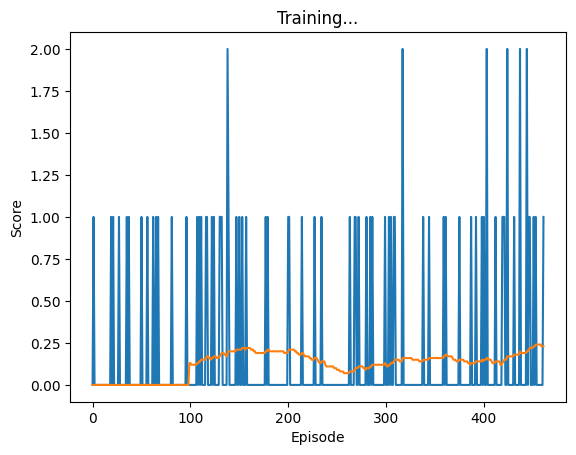

<Figure size 640x480 with 0 Axes>

In [ ]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 5000
else:
    num_episodes = 500

# num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(
                observation, dtype=torch.float32, device=device
            ).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[
                key
            ] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            print(
                f"Episode: {i_episode}/{num_episodes} ({round((i_episode/num_episodes)*100)} %)"
            )
            episode_scores.append(env.score)
            plot_scores()
            break

print("Complete")
torch.save(policy_net.state_dict(), "models/snake_dqntest.pth")
plot_scores(show_result=True)
plt.ioff()
plt.show()